In [ ]:
!pip install autogluon.timeseries[all] seaborn[stats] prophet

In [ ]:
from pandas import DataFrame
import numpy as np
import pandas as pd
from datetime import timedelta
import calendar
from prophet import Prophet


In [ ]:
df = pd.read_csv("drive/MyDrive/Colab Data/AutoGluon/PJM_Load_hourly.csv")
df.head(10)

,Datetime,PJM_Load_MW
0,4/1/1998 1:00,22259
1,4/1/1998 2:00,21244
2,4/1/1998 3:00,20651
3,4/1/1998 4:00,20421
4,4/1/1998 5:00,20713
5,4/1/1998 6:00,22526
6,4/1/1998 7:00,25772
7,4/1/1998 8:00,28724
8,4/1/1998 9:00,30075
9,4/1/1998 10:00,30689


In [ ]:
#prep data in required prophet format
df['ds'] = pd.to_datetime(df['Datetime'])
df['y'] = df['PJM_Load_MW']

df = df[['ds', 'y']]
df.head(10)


,ds,y
0,1998-04-01 01:00:00,22259
1,1998-04-01 02:00:00,21244
2,1998-04-01 03:00:00,20651
3,1998-04-01 04:00:00,20421
4,1998-04-01 05:00:00,20713
5,1998-04-01 06:00:00,22526
6,1998-04-01 07:00:00,25772
7,1998-04-01 08:00:00,28724
8,1998-04-01 09:00:00,30075
9,1998-04-01 10:00:00,30689


In [ ]:
#instantiate prophet and build the model
m = Prophet(changepoint_prior_scale=0.05)
model = m.fit(df)

DEBUG:cmdstanpy:input tempfile: /tmp/tmplh9ikfvi/l0wdnowy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplh9ikfvi/dkgl1jba.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74288', 'data', 'file=/tmp/tmplh9ikfvi/l0wdnowy.json', 'init=/tmp/tmplh9ikfvi/dkgl1jba.json', 'output', 'file=/tmp/tmplh9ikfvi/prophet_modelgfo0xc0r/prophet_model-20230622005147.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:51:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:52:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
test_data = pd.read_csv("drive/MyDrive/Colab Data/AutoGluon/test_energy.csv")
test = pd.DataFrame()
test['ds'] = test_data['timestamp']
test['y'] = test_data['target']
test.head(10)

,ds,y
0,12/30/2001 0:00,30080
1,12/30/2001 1:00,28326
2,12/30/2001 2:00,27362
3,12/30/2001 3:00,27108
4,12/30/2001 4:00,26865
5,12/30/2001 5:00,26808
6,12/30/2001 6:00,27352
7,12/30/2001 7:00,28403
8,12/30/2001 8:00,29305
9,12/30/2001 9:00,30329


In [ ]:
future = model.make_future_dataframe(periods=len(test), freq='H')
forecast = model.predict(future)

In [ ]:
forecast[['ds', 'trend', 'weekly', 'yearly', 'yhat']].tail()

,ds,trend,weekly,yearly,yhat
32891,2001-12-31 20:00:00,29263.913565,1363.027626,1193.271792,35822.854793
32892,2001-12-31 21:00:00,29263.674463,1412.642039,1193.213146,35297.348906
32893,2001-12-31 22:00:00,29263.435361,1453.866283,1193.157975,33928.318868
32894,2001-12-31 23:00:00,29263.196259,1487.081009,1193.106383,31915.365547
32895,2002-01-01 00:00:00,29262.957157,1512.720010,1193.058474,29702.531773


In [ ]:
from sklearn import metrics

hours_to_forecast=49
r2_score = metrics.r2_score(list(test['y']), list(forecast.loc[len(forecast)-hours_to_forecast:,'yhat']))
mae = metrics.mean_absolute_error(list(test['y']), list(forecast.loc[len(forecast)-hours_to_forecast:,'yhat']))
mse = metrics.mean_squared_error(list(test['y']), list(forecast.loc[len(forecast)-hours_to_forecast:,'yhat']))

print(f'r2_score : {r2_score}')
print(f'mae : {mae}')
print(f'mse : {mse}')

r2_score : -0.3393820504792866
mae : 2972.2425067305667
mse : 12503110.764199948


In [ ]:
from autogluon.timeseries import TimeSeriesDataFrame

if not 'item_id' in df:
  df.insert(0, "item_id", "H1")

plot_data = TimeSeriesDataFrame.from_data_frame(df,timestamp_column='ds')
plot_data.head()

/usr/local/lib/python3.10/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/local/lib/python3.10/dist-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda20CUDACachingAllocator9allocatorE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


y
item_id timestamp                 
H1      1998-04-01 01:00:00  22259
        1998-04-01 02:00:00  21244
        1998-04-01 03:00:00  20651
        1998-04-01 04:00:00  20421
        1998-04-01 05:00:00  20713

In [ ]:
fix_plot_data = plot_data.to_regular_index(freq='H')
print(f"Data has frequency '{fix_plot_data.freq}'")

Data has frequency 'H'


In [ ]:
print(f"Does it have any missing data? '{fix_plot_data.isnull().values.any()}'")

Does it have any missing data? 'True'


In [ ]:
if fix_plot_data.isnull().values.any():
  fix_plot_data = fix_plot_data.fill_missing_values()

print(f"Does it have any missing data? '{fix_plot_data.isnull().values.any()}'")

Does it have any missing data? 'False'


In [ ]:
# import seaborn as sb
# import matplotlib.pyplot as plt
# from autogluon.timeseries import TimeSeriesDataFrame

# sb.set_style("darkgrid")
# # TimeSeriesDataFrame can also be loaded directly from a file
# test_data = TimeSeriesDataFrame.from_path("drive/MyDrive/Colab Data/AutoGluon/test_energy.csv")



# plt.figure(figsize=(20, 3))

# item_id = "H1"
# y_past = fix_plot_data.loc[item_id]["y"]
# y_pred = forecast["yhat"]
# y_test = test_data.loc["H1"]["target"][-48:]

# plt.plot(y_past, label="Past time series values")
# plt.plot(y_pred, label="Predicted forecast")
# plt.plot(y_test, label="Future time series values")

# # plt.fill_between(
# #     y_pred.index, y_pred["0.1"], y_pred["0.9"], color="red", alpha=0.1, label=f"10%-90% confidence interval"
# # )
# plt.legend();

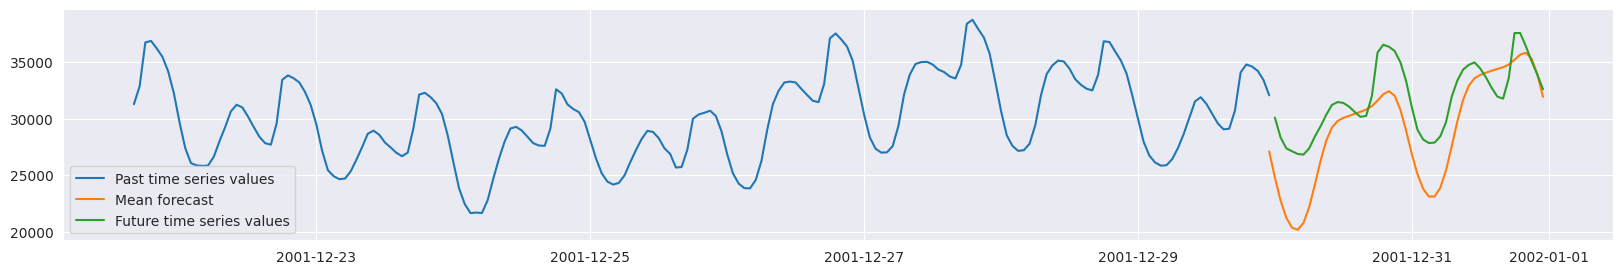

In [ ]:
import seaborn as sb
import matplotlib.pyplot as plt

sb.set_style("darkgrid")

# Convert 'ds' to datetime in forecast dataframe
forecast['ds'] = pd.to_datetime(forecast['ds'])

# Convert 'ds' to datetime in historical dataframe
df['ds'] = pd.to_datetime(df['ds'])

# Convert 'ds' to datetime in test dataframe
test['ds'] = pd.to_datetime(test['ds'])

# Set the figure size
plt.figure(figsize=(20, 3))

# Get the last 200 data points of historical data
start_time_hist = df['ds'].iloc[-200]

# Get the corresponding data from the historical dataframe
df_limit = df[df['ds'] >= start_time_hist]

# Plot the last 200 data points from the historical data
plt.plot(df_limit['ds'], df_limit['y'], label="Past time series values")

# Get the start time of the forecasted data
start_time_forecast = df['ds'].max()

# Get the end time of the forecasted data (48 hours after the start)
end_time_forecast = start_time_forecast + pd.Timedelta(hours=48)

# Get the corresponding data from the forecast dataframe
forecast_limit = forecast[(forecast['ds'] >= start_time_forecast) & (forecast['ds'] <= end_time_forecast)]

# Plot the forecasted data
plt.plot(forecast_limit['ds'], forecast_limit['yhat'], label="Mean forecast")

# Get the corresponding data from the test dataframe
test_limit = test[(test['ds'] >= start_time_forecast) & (test['ds'] <= end_time_forecast)]

# Plot the test data
plt.plot(test_limit['ds'], test_limit['y'], label="Future time series values")

# Add the legend
plt.legend();

# Show the plot
plt.show()

# Hardcore Model Tuning (only needs to be run once to get the params)

In [ ]:
# #this is 'Merica so add a couple of holidays where energy usage might be higher

# black_friday = pd.DataFrame({
#   'holiday': 'black_friday',
#   'ds': pd.to_datetime(['1999-11-26','2000-11-24', '2001-11-23', '2002-11-29']),
#   'lower_window': -10,
#   'upper_window': 1,
# })
# xmas = pd.DataFrame({
#   'holiday': 'xmas',
#   'ds': pd.to_datetime(['1999-12-24', '1999-12-25', '1999-12-26','2000-12-24', '2000-12-25', '2000-12-26', '2001-12-24', '2001-12-25', '2001-12-26']),
#   'lower_window': -5,
#   'upper_window': 1,
# })

# tg = pd.DataFrame({
#   'holiday': 'xmas',
#   'ds': pd.to_datetime(['1999-11-25', '2000-11-23', '2001-12-22','2002-12-28']),
#   'lower_window': -5,
#   'upper_window': 1,
# })

# holidays = pd.concat((black_friday, xmas))

In [ ]:
# # Create the grid
# changepoint_prior_scale = [0.01, 0.03, 0.05, 0.07] # default 0.05
# seasonality_prior_scale = [1, 5, 10, 15] # default 10
# holidays_prior_scale = [1, 5, 10, 15] # default 10
# seasonality_mode = ['additive']
# changepoint_range = [0.6, 0.7, 0.8, 0.9] # default 0.8

# # Compute the total number of iterations
# total_iter = len(changepoint_prior_scale)*len(seasonality_prior_scale)*len(holidays_prior_scale)*len(seasonality_mode)*len(changepoint_range)
# print(f'Number of iterations : {total_iter}')

# # Loop over the parameters, build and assess the models
# grid_search_results = []
# iteration = 1
# for cps in changepoint_prior_scale:
#     for sps in seasonality_prior_scale:
#         for hps in holidays_prior_scale:
#             for sm in seasonality_mode:
#                 for cr in changepoint_range:
#                     m = Prophet(holidays=holidays,
#                                  changepoint_prior_scale = cps,
#                                  seasonality_prior_scale = sps,
#                                  holidays_prior_scale = hps,
#                                  seasonality_mode = sm,
#                                  changepoint_range = cr)
#                     m.add_country_holidays(country_name='US')
#                     model = m.fit(df)
#                     future = model.make_future_dataframe(periods=len(test), freq='H')
#                     forecast = model.predict(future)

#                     r2_score = metrics.r2_score(list(test['y']), list(forecast.loc[len(forecast)-hours_to_forecast:,'yhat']))
#                     mae = metrics.mean_absolute_error(list(test['y']), list(forecast.loc[len(forecast)-hours_to_forecast:,'yhat']))
#                     mse = metrics.mean_squared_error(list(test['y']), list(forecast.loc[len(forecast)-hours_to_forecast:,'yhat']))

#                     print(f'iteration : {iteration} / {total_iter} ')
#                     print(f'r2_score : {r2_score}')
#                     print(f'mae : {mae}')
#                     print(f'mse : {mse}')

#                     grid_search_results.append([iteration, cps, sps, hps, sm, cr, r2_score, mae, mse])
#                     iteration += 1

# # Store the results in a dataframe
# grid_search_df = pd.DataFrame(grid_search_results, columns = ['iteration', 'cps', 'sps', 'hps', 'sm', 'cr', 'r2_score', 'mae', 'mse'])

In [ ]:
# grid_search_df.sort_values('mse', ascending = True).head()

In [ ]:
# replace these with the output of the hyperparameter tuning above
changepoint_prior_scale = 0.05 # default 0.05
seasonality_prior_scale = 10 # default 10
holidays_prior_scale = 5 # default 10
seasonality_mode = 'additive'
changepoint_range = 0.6 # default 0.8

# Creating an instance of the Prophet class and training the model
m3 = Prophet(holidays=holidays,
            changepoint_prior_scale = changepoint_prior_scale,
            seasonality_prior_scale = seasonality_prior_scale,
            holidays_prior_scale = holidays_prior_scale,
            seasonality_mode = seasonality_mode,
            changepoint_range = changepoint_range)
m3.add_country_holidays(country_name='US')
model3 = m3.fit(df)

future3 = model3.make_future_dataframe(periods=len(test), freq='H')
forecast3 = model3.predict(future3)

DEBUG:cmdstanpy:input tempfile: /tmp/tmplh9ikfvi/jw5joygm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplh9ikfvi/gq04vr46.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68952', 'data', 'file=/tmp/tmplh9ikfvi/jw5joygm.json', 'init=/tmp/tmplh9ikfvi/gq04vr46.json', 'output', 'file=/tmp/tmplh9ikfvi/prophet_modelozfyj2jp/prophet_model-20230622010020.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:00:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:01:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


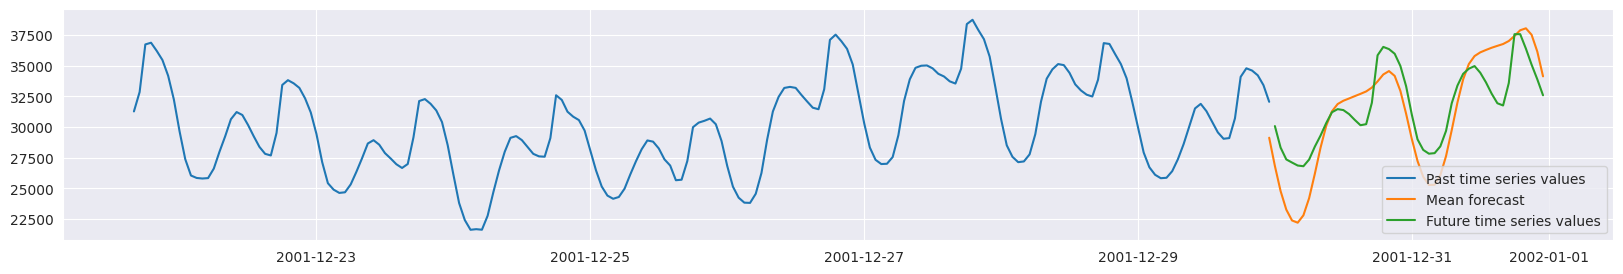

In [ ]:
#then re-plot
import seaborn as sb
import matplotlib.pyplot as plt

sb.set_style("darkgrid")

#use new data
forecast = forecast3

# Convert 'ds' to datetime in forecast dataframe
forecast['ds'] = pd.to_datetime(forecast['ds'])

# Convert 'ds' to datetime in historical dataframe
df['ds'] = pd.to_datetime(df['ds'])

# Convert 'ds' to datetime in test dataframe
test['ds'] = pd.to_datetime(test['ds'])

# Set the figure size
plt.figure(figsize=(20, 3))

# Get the last 200 data points of historical data
start_time_hist = df['ds'].iloc[-200]

# Get the corresponding data from the historical dataframe
df_limit = df[df['ds'] >= start_time_hist]

# Plot the last 200 data points from the historical data
plt.plot(df_limit['ds'], df_limit['y'], label="Past time series values")

# Get the start time of the forecasted data
start_time_forecast = df['ds'].max()

# Get the end time of the forecasted data (48 hours after the start)
end_time_forecast = start_time_forecast + pd.Timedelta(hours=48)

# Get the corresponding data from the forecast dataframe
forecast_limit = forecast[(forecast['ds'] >= start_time_forecast) & (forecast['ds'] <= end_time_forecast)]

# Plot the forecasted data
plt.plot(forecast_limit['ds'], forecast_limit['yhat'], label="Mean forecast")

# Get the corresponding data from the test dataframe
test_limit = test[(test['ds'] >= start_time_forecast) & (test['ds'] <= end_time_forecast)]

# Plot the test data
plt.plot(test_limit['ds'], test_limit['y'], label="Future time series values")

# Add the legend
plt.legend();

# Show the plot
plt.show()